In [2]:
import cv2
import numpy as np
import imutils
from matplotlib import pyplot as plt

In [11]:
img = cv2.imread("img.jpg")

In [12]:
def shadow_remove(img):
    rgb_planes = cv2.split(img)
    result_norm_planes = []
    for plane in rgb_planes:
        dilated_img = cv2.dilate(plane, np.ones((7, 7), np.uint8),iterations=5)
        
        # Use bilateral filter instead of medianBlur
        bg_img = cv2.bilateralFilter(dilated_img, d=20, sigmaColor=75, sigmaSpace=75)
        
        diff_img = 255 - cv2.absdiff(plane, bg_img)
        norm_img = cv2.normalize(diff_img, None, alpha=20, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)
        result_norm_planes.append(norm_img)
    
    shadowremov = cv2.merge(result_norm_planes)
    return shadowremov

In [13]:
def preprocess(image):

    img_copy = cv2.cvtColor(image.copy(), cv2.COLOR_BGR2GRAY)
    
    bg_img = cv2.bilateralFilter(img_copy, d=55, sigmaColor=75, sigmaSpace=75)
    divided = cv2.divide(img_copy, bg_img, scale=255)

    clahe = cv2.createCLAHE(clipLimit = 2)
    final_img = clahe.apply(divided) + 30

    final_img = cv2.GaussianBlur(final_img, (3,3), sigmaX=33, sigmaY=33)
    (thresh, final_img) = cv2.threshold(final_img, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

    final_img = cv2.cvtColor(final_img, cv2.COLOR_GRAY2BGR)

    final_img = cv2.bitwise_not(final_img) 

    return final_img

In [14]:
def order_points(points):
    # Convert input to numpy array if not already
    points = np.array(points, dtype="float32")
    rect = np.zeros((4, 2), dtype="float32")  # To hold corners

    # Calculate sums and differences
    s = points.sum(axis=1)  # x + y
    # diff = np.diff(points, axis=1).flatten()  # y - x

    # Assign corners
    rect[0] = points[np.argmin(s)]  # Top-left: smallest sum
    rect[2] = points[np.argmax(s)]  # Bottom-right: largest sum

    # Remove assigned points
    remaining = [i for i in range(len(points)) if i not in [np.argmin(s), np.argmax(s)]]
    remaining_points = points[remaining]

    # Assign remaining corners based on difference
    diff_remaining = np.diff(remaining_points, axis=1).flatten()
    rect[1] = remaining_points[np.argmin(diff_remaining)]  # Top-right: smallest difference
    rect[3] = remaining_points[np.argmax(diff_remaining)]  # Bottom-left: largest difference

    return rect

def four_point_transform(image, pts):

    rect = order_points(pts)
    (tl, tr, br, bl) = rect 

    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2)) 
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))

    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))
    
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype = "float32")

    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))

    return warped

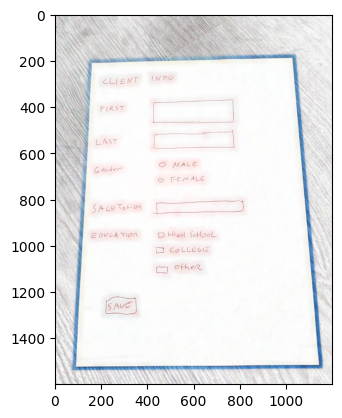

In [15]:
plt.imshow(shadow_remove(img))

In [16]:
class EditWindow():

    def __init__(self, points) -> None:
    
        self.radius = 15
        self.selected_point = None
        self.points = points

        # Create window and set mouse callback
        cv2.namedWindow("Homography Transform")
        cv2.setMouseCallback("Homography Transform", self.mouse_callback)

    def draw_points(self, img, points):
        """Draw circles around each point and display instruction text."""
        for point in points:

            cv2.circle(img, point[0], self.radius, (0, 255, 0), 2)
            cv2.circle(img, point[0], 1, (0, 0, 255), -1)
        
        # Display instructions on the image
        cv2.putText(img, "Press 'q' to extract", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 255), 1)
        cv2.putText(img, "Drag the circles to correct", (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 255), 1)

    def find_closest_point(self, x, y):
        """Return index of the closest point within the radius, or None if no point is close."""
        for i, (px, py) in enumerate([p[0] for p in self.points]):
            if (x - px)**2 + (y - py)**2 < self.radius**2:
                return i
        return None

    def mouse_callback(self, event, x, y, flags, param):

        if event == cv2.EVENT_LBUTTONDOWN:
            # Check if a point is clicked and select it for dragging
            self.selected_point = self.find_closest_point(x, y)

        elif event == cv2.EVENT_MOUSEMOVE:
            # Move the selected point if any
            if self.selected_point is not None:
                self.points[self.selected_point] = (x, y)

        elif event == cv2.EVENT_LBUTTONUP:
            # Release the selected point
            self.selected_point = None

    def run(self, image):

        while True:
            # Draw points on a copy of the image
            img_copy = image.copy()
            self.draw_points(img_copy, self.points)

            # Display the image
            cv2.imshow("Homography Transform", img_copy)

            # Exit on 'q' key press
            key = cv2.waitKey(1)
            if key & 0xFF == ord('q'):
                break

        cv2.destroyAllWindows()


In [19]:
ratio = img.shape[0] / 500.0
orig = img.copy()
image = imutils.resize(preprocess(shadow_remove(img)), height = 500)

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (5, 5), 0)
edged = cv2.Canny(gray, 100, 255)

cnts = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

cnts = imutils.grab_contours(cnts)
cnts = sorted(cnts, key = cv2.contourArea, reverse = True)[:5]


for c in cnts:
    
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.02 * peri, True)
    
    if len(approx) == 4:
        editWindow = EditWindow(approx)
        editWindow.run(image)
        screenCnt = approx
        break

warped = four_point_transform(orig, screenCnt.reshape(4, 2) * ratio)
warped = imutils.resize(warped, width = 500)
cv2.imshow(mat=warped,winname="result")
cv2.waitKey(0)
cv2.destroyAllWindows()



(635, 500, 3)


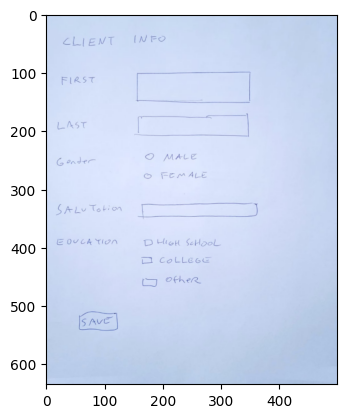

In [20]:
plt.imshow(warped[:,:,::-1])
print(warped.shape)